In [1]:
# Training deep neural networks on GPU


In [2]:
import torch
import numpy as np
import torchvision
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader

In [3]:
dataset = MNIST(root='data/',
               download=True,
               transform=ToTensor())
# transform converts images from png to tensors

In [4]:
# Pick a random val_pct fraction of the images for validation set
def split_indices(n, val_pct):
    n_val = int(val_pct*n)
    # random permutation of 0 to n-1
    idxs = np.random.permutation(n)
    # Picks [n_val:] indices for validation set
    return idxs[n_val:], idxs[:n_val]


In [5]:
train_indices, val_indices = split_indices(len(dataset), val_pct=0.2)

print(len(train_indices), len(val_indices))
print('Sample val indices: ', val_indices[:20])

48000 12000
Sample val indices:  [29077 32424  9180 44445 13532 51784 12563 18060 49251 42101 24391 34825
 26763 24914 55521 32721 33884 23517 54077 53261]


In [6]:
batch_size=100
# Training sampler/data loader
train_sampler = SubsetRandomSampler(train_indices)
# DataLoader splits data into batches and returns batches in a for loop
# RandomSampler randomly shuffles the data for each batch - improves gradient descent 
#
train_dl = DataLoader(dataset,
                     batch_size,
                     sampler=train_sampler)
# Validation sampler 
valid_sampler = SubsetRandomSampler(val_indices)
valid_dl = DataLoader(dataset,
                     batch_size,
                     sampler=valid_sampler)

In [7]:
"""Instead of using a single nn.Linear object to transform a batch of inputs (pixel intensities) into a batch of outputs (class probabilities), we'll use two nn.Linear objects. Each of these is called a layer in the network.

The first layer (also known as the hidden layer) will transform the input matrix of shape batch_size x 784 into an intermediate output matrix of shape batch_size x hidden_size, where hidden_size is a preconfigured parameter (e.g. 32 or 64).

The intermediate outputs are then passed into a non-linear activation function, which operates on individual elements of the output matrix.

The result of the activation function, which is also of size batch_size x hidden_size, is passed into the second layer (also knowns as the output layer), which transforms it into a matrix of size batch_size x 10, identical to the output of the logistic regression model."""

"Instead of using a single nn.Linear object to transform a batch of inputs (pixel intensities) into a batch of outputs (class probabilities), we'll use two nn.Linear objects. Each of these is called a layer in the network.\n\nThe first layer (also known as the hidden layer) will transform the input matrix of shape batch_size x 784 into an intermediate output matrix of shape batch_size x hidden_size, where hidden_size is a preconfigured parameter (e.g. 32 or 64).\n\nThe intermediate outputs are then passed into a non-linear activation function, which operates on individual elements of the output matrix.\n\nThe result of the activation function, which is also of size batch_size x hidden_size, is passed into the second layer (also knowns as the output layer), which transforms it into a matrix of size batch_size x 10, identical to the output of the logistic regression model."

In [8]:
# We use ReLU activation function max(0, x) - if value is - it becomes 0

# Batch_size should be as large as possible while the training is still fast

# By adding a hidden layer the model can capture a non-linear relationship

# 



In [9]:
import torch.nn.functional as F
import torch.nn as nn

In [10]:
# have to treat train_dl as loop 
for xb, yb, in train_dl:
    print(xb.shape)
    break

torch.Size([100, 1, 28, 28])


In [11]:
class MnistModel(nn.Module):
    """feedforward nn with 1 hidden layer"""
    def __init__(self, in_size, hidden_size, out_size):
        super().__init__()
        # Hidden layer
        self.linear1 = nn.Linear(in_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, out_size)
        
    def forward(self, xb):
        # xb.view reshapes matrix (ensures the same block of mem is used)
        # xb.size(0) ensures that the first dimension is still used
        xb = xb.view(xb.size(0), -1)
        out = self.linear1(xb)
        out = F.relu(out)
        out = self.linear2(out)
        return out
        
        
        
        
        

In [12]:
input_size = 784 #28x28
num_classes = 10 #10 possible outputs (numbers)

model = MnistModel(input_size, hidden_size=32,
                  out_size = num_classes)



In [13]:
# Shapes of each model: weights and bias matrices
for t in model.parameters():
    print(t.shape)


torch.Size([32, 784])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])


In [14]:
for images, labels in train_dl:
    outputs = model(images)
    loss = F.cross_entropy(outputs, labels)
    print('Loss', loss.item())
    break

print('outputs.shape: ', outputs.shape)
print('Sample outputs : \n', F.softmax(outputs)[1])

Loss 2.3217265605926514
outputs.shape:  torch.Size([100, 10])
Sample outputs : 
 tensor([0.0861, 0.1028, 0.1090, 0.1141, 0.1080, 0.0987, 0.1055, 0.0875, 0.0924,
        0.0959], grad_fn=<SelectBackward>)


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


In [15]:
# ReLU introduces non-linearity 
# super().__init__() ensures that the __init__ function is called

# Reveals if appropriate GPU is present

# torch.cuda.is_available()

# helper function to use GPU if available

def get_default_device():
    if torch.cuda.is_available():
        torch.device('cuda')
    else:
        return torch.device('cpu')
    
device = get_default_device()
device

device(type='cpu')

In [16]:
def to_device(data, device):
    """move tensors to chosen device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    
    return data.to(device, non_blocking=True)

In [17]:
for images, labels in train_dl:
    print(images.shape)
    images = to_device(images, device)
    print(images.device)
    break

torch.Size([100, 1, 28, 28])
cpu


In [18]:
"""
You should only put data on the GPU right before using a model. Wrap the
dataloader to move data to a device, and yield a batch of data after moving 
device.
"""


class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl:
            # Yield pauses function execution to return the next element
            yield to_device(b, self.device)
    def __len__(self):
        return len(self.dl)

# Data is automatically cleared from GPU/CPU memory

In [19]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [38]:
def loss_batch(model, loss_func, xb, yb, opt=None, metric=None):
    preds = model(xb)
    loss = loss_func(preds, yb)
    
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()
    
    metric_result=None
    if metric is not None:
        metric_result = metric(preds, yb)
        
    return loss.item(), len(xb), metric_result
        
def evaluate(model, loss_fn, valid_dl, metric=None):
    with torch.no_grad():
        results = [loss_batch(model, loss_fn, xb, yb, metric=metric)
                 for xb,yb in valid_dl]
        losses, nums, metrics = zip(*results)
        # total size of dataset
        total = np.sum(nums)
        # avg loss across batches
        avg_loss = np.sum(np.multiply(losses, nums)/total)
        avg_metric = None
        if metric is not None:
            # avg of metric across batches
            avg_metric = np.sum(np.multiply(metrics,nums)) / total
    return avg_loss, total, avg_metric

def fit(epochs, lr, model, loss_fn, train_dl, valid_dl, metric=None,
       opt_fn=None):
    
    losses, metrics = [], []
    # Set up optimizer
    if opt_fn is None: opt_fn = torch.optim.SGD
    opt = opt_fn(model.parameters(), lr=lr)
    
    # Training
    for epoch in range(epochs):
        for xb, yb in train_dl:
            loss_batch(model, loss_fn, xb, yb, opt)
        
        # Evaluation
        result = evaluate(model, loss_fn, valid_dl, metric)
        val_loss, total, val_metric = result
        
        # Recording
        losses.append(val_loss)
        metrics.append(val_metric)
        
        if metric is None:
            print('Epoch [{}/{}], Loss: {:.4f}'
                 .format(epoch+1, epochs, val_loss))
        else:
            print('Epoch [{}/{}], Loss: {:.4f}, {}, {:.4f}'
                 .format(epoch+1, epochs, val_loss,
                        metric.__name__, val_metric))
            
    return losses, metrics

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.sum(preds==labels).item()/len(preds)
        
        
    

In [39]:
model = MnistModel(input_size, hidden_size=32, out_size=num_classes)
to_device(model, device)

MnistModel(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)

In [40]:
# test on validation with initial w and b

val_loss, total, val_acc = evaluate(model, F.cross_entropy,
                                   valid_dl, metric=accuracy)
print('Loss: {:.4f}, Accuracy: {:.4f}'.format(val_loss, val_acc))

Loss: 2.3241, Accuracy: 0.0870


In [41]:
# Train it

losses1, metrics1 = fit(10, .5, model, F.cross_entropy, train_dl,
                       valid_dl, accuracy)

Epoch [1/10], Loss: 0.2117, accuracy, 0.9355
Epoch [2/10], Loss: 0.1691, accuracy, 0.9519
Epoch [3/10], Loss: 0.1491, accuracy, 0.9556
Epoch [4/10], Loss: 0.1363, accuracy, 0.9602
Epoch [5/10], Loss: 0.1293, accuracy, 0.9630
Epoch [6/10], Loss: 0.1308, accuracy, 0.9623
Epoch [7/10], Loss: 0.1381, accuracy, 0.9592
Epoch [8/10], Loss: 0.1277, accuracy, 0.9644
Epoch [9/10], Loss: 0.1353, accuracy, 0.9625
Epoch [10/10], Loss: 0.1291, accuracy, 0.9632


In [42]:
import matplotlib.pyplot as plt
%matplotlib inline

Text(0.5, 1.0, 'Accuracy vs No. of Epochs')

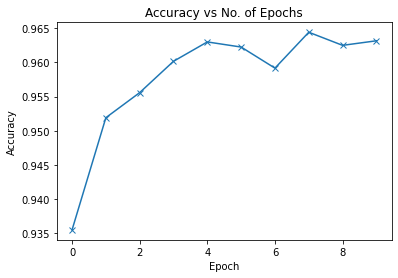

In [43]:
accuracies = metrics1
plt.plot(accuracies, '-x')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs No. of Epochs')